In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.random.seed(42)

#from keras.layers import merge
from src.models.catdata import *
from src.models.catmodel import *
from src.models.catsegnet import *
from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc, auc_pr, auc_pr_multiclass, dummy_metric
#import rasterio.plot as rioplot
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

import pandas as pd

import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from keras.models import load_model
from keras.callbacks import RemoteMonitor, TensorBoard, ReduceLROnPlateau, EarlyStopping, History
from keras import backend as keras

sys.path.append("/home/ubuntu/roaddetection/")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.io as io
from pathlib import Path
import numpy as np

%matplotlib inline

color_dict = [0, 127, 255]
classweights = [1.0, 1.503971686212565, 1.9888096014508438]

Using TensorFlow backend.


In [3]:
def labelVisualize(num_class,color_dict,img):
    img
    print(np.unique(img))
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        print(img_out[img == i,:])
        img_out[img == i,:] = color_dict[i]
    return img_out# / 255

In [4]:
def softmax(vec):
    exp = np.exp(vec)
    return exp/np.sum(exp)

In [5]:
def show_prediction(n, sat, map, predict):
    sat = io.imread(sat)
    q = io.imread(predict)
    
    p = q*0
    s = np.shape(q)
    k = np.zeros((s[0], s[1]))
    numUn = 0
    numP = 0
    for i in range(len(q[0])):
        for j in range(len(q[1])):
            if np.argmax(q[i,j,:]) == 1:
                #print(np.argmax(softmax(q[i,j,:], classweights)))
                numP += 1
                #print((q[i,j,:]), softmax(q[i,j,:]), np.argmax(q[i,j,:]), q[i,j,np.argmax(q[i,j,:])])
            elif np.argmax(q[i,j,:]) == 2:
                #print((q[i,j,:]), softmax(q[i,j,:]), np.argmax(q[i,j,:]), q[i,j,np.argmax(q[i,j,:])])
                numUn += 1
            p[i,j,(np.argmax(q[i,j,:]))] = 1
            k[i, j] = (np.argmax(q[i,j,:]))*127
    map = io.imread(map)
#     map = map.reshape((512,512))
    
    figH1 = plt.figure(n, figsize=(25, 6))
    plt.subplot(1, 5, 1)
    plt.imshow(sat)
    
    plt.subplot(1, 5, 2)
    plt.imshow(map, cmap='gray')

    plt.subplot(1, 5, 3)
    plt.imshow(k, cmap='gray')
    plt.subplot(1, 5, 4)
    plt.imshow(p[..., 1], cmap='gray')
    plt.subplot(1, 5, 5)
    plt.imshow(p[..., 2], cmap='gray')

    plt.colorbar()
    figH1.show()
    print(numP, numUn)

In [6]:
test_dir="../../data/test/"

In [7]:
def get_image_paths(file_name):
    sat_rgb = test_dir + "sat_rgb/" + file_name
    map =  test_dir + "map/" + file_name
    predict = test_dir + "predict/" + file_name
    return {"sat": sat_rgb, "map": map, "predict":predict}

In [8]:
!ls -l ../../models

total 12764644
-rw-rw-r-- 1 ubuntu ubuntu  26247168 Sep  9 17:07 0905_1500_NL_multiCat_unet.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  61636608 Sep  9 17:02 models_unet_borneo_and_harz_05_09_16_22.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  63058688 Sep  7 09:23 multiCat_segnet_0907_1115_e-15_r-1.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  63059008 Sep  7 09:32 multiCat_segnet_0907_1115_e-15_r-2.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  63059024 Sep  7 09:40 multiCat_segnet_0907_1115_e-15_r-3.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  63059752 Sep  7 09:49 multiCat_segnet_0907_1115_e-15_r-4.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  63059752 Sep  7 10:36 multiCat_segnet_0907_1115_e-15_r-5.hdf5
-rw-rw-r-- 1 ubuntu ubuntu 372578992 Sep  8 15:47 multicat_unet_NL_th0-0.01_th1-0.025_bs-3_ep-15_r-1.hdf5
-rw-rw-r-- 1 ubuntu ubuntu 372578992 Sep  8 16:02 multicat_unet_NL_th0-0.01_th1-0.025_bs-3_ep-15_r-2.hdf5
-rw-rw-r-- 1 ubuntu ubuntu 372578992 Sep  8 16:15 multicat_unet_NL_th0-0.01_th1-0.025_bs-3_ep-15_r-3.hdf5
-rw-rw-r-- 1 ubuntu ubuntu 372578992 Sep

In [53]:
model = unet((256, 256, 4), 3)
model.load_weights('../../models/multicat_unet_NL_th0-0.01_th1-0.08_bs-3_ep-15_r-4.hdf5')
#model.load_weights('../../models/multicat_unet_NL_th0-0.0_th1-0.0_bs-3_ep-5_r-3.hdf5')

/home/ubuntu/roaddetection/src/models/catmodel.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (1, 1), activation="relu", padding="same")`
  conv10 = layers.Conv2D(nClasses, 1, 1, activation='relu',border_mode='same')(conv9)
/home/ubuntu/roaddetection/src/models/catmodel.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  model = Model(input=inputs, output=conv10)


In [54]:
testGene = testGenerator("../../data/test/sat",target_size=(256, 256),as_gray=False)
n = 0
for img, name in testGene:
    if n > 80:
        results = model.predict(img, batch_size=1)
        saveResult("../../data/test/predict", results, name, True, 3)
    n += 1
    if(n>80+5):
        break

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0 148
0 677
0 0
0 2271
0 1893


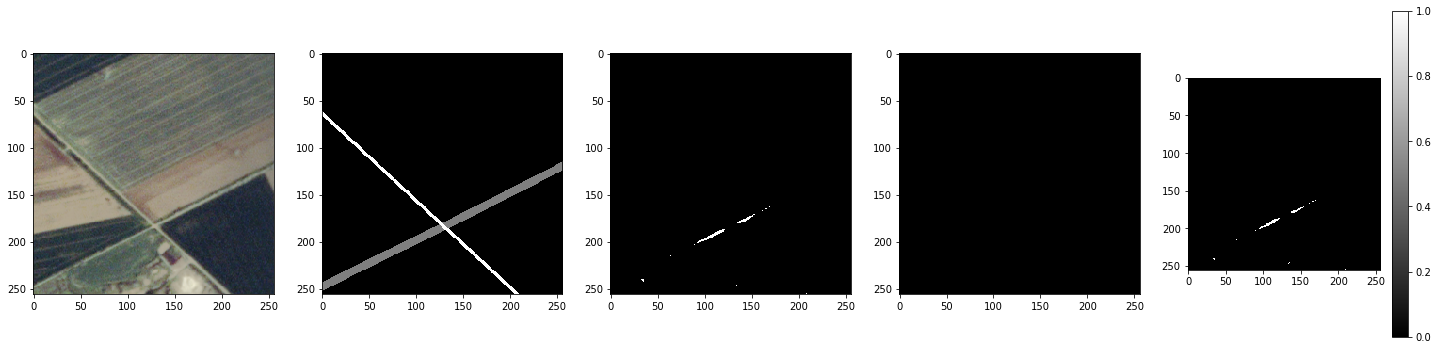

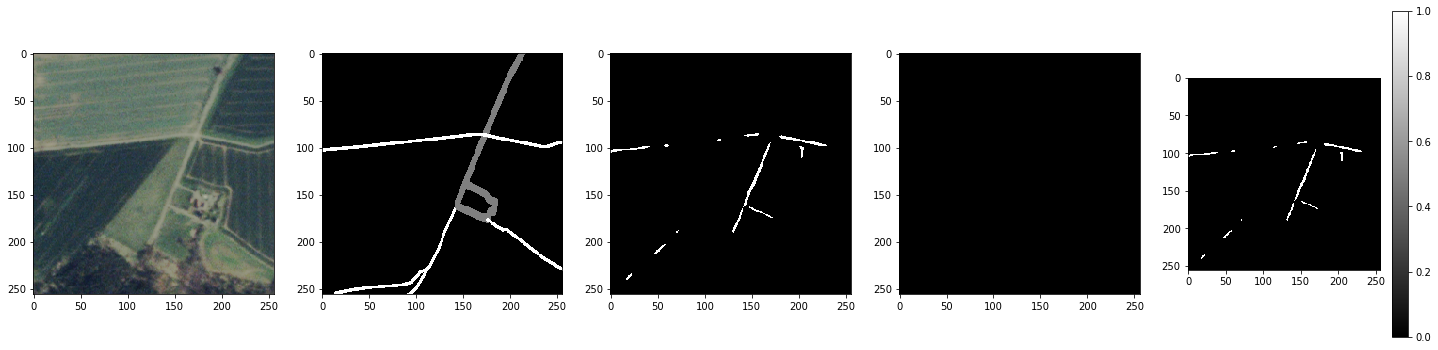

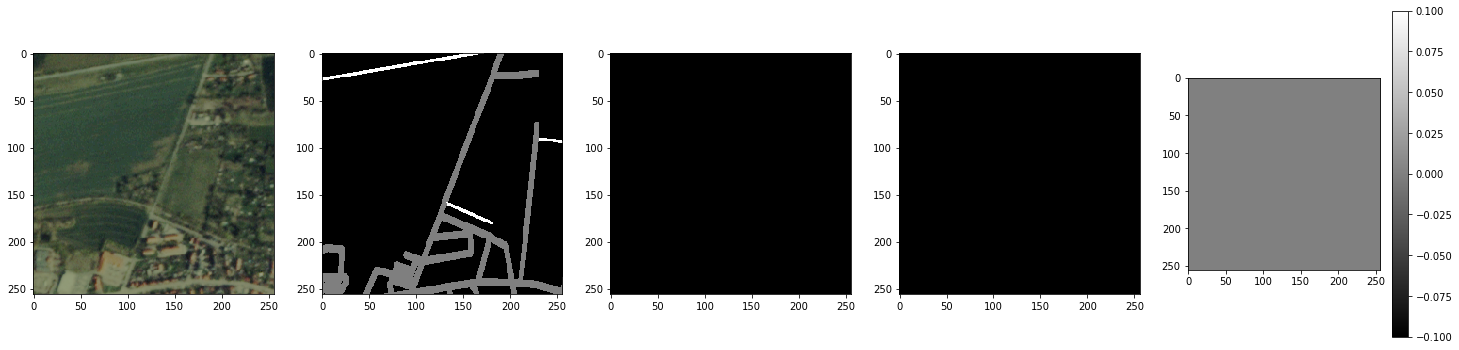

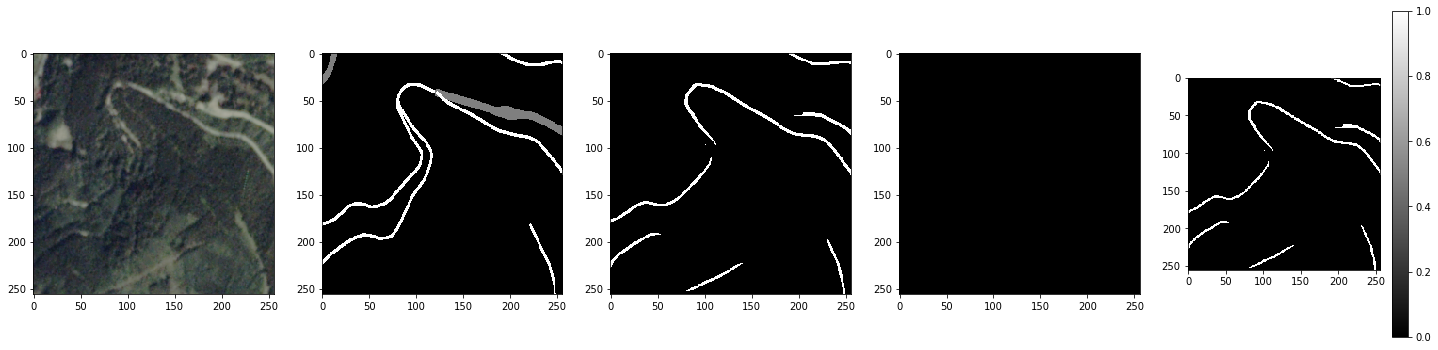

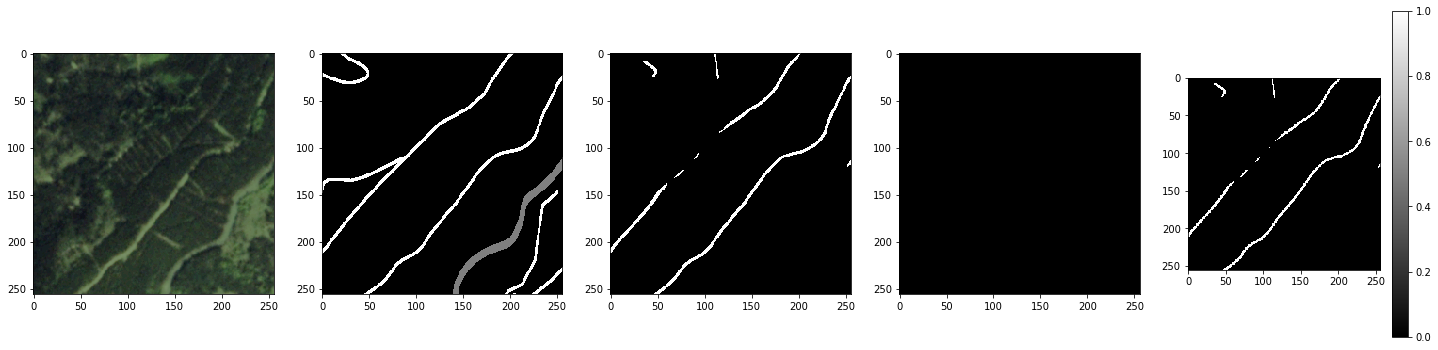

In [56]:
n = 0
for file in Path("../../data/test/predict").iterdir():
    if file.name.endswith(('.tiff', '.tif')):
        show_prediction(n, **get_image_paths(file.name))
        n +=1
        if(n>50):
            break

In [27]:
print(np.exp([.0000000001])/np.exp([1.]))

[0.36787944]
